In [71]:
# Section 1: Data Loading and Preprocessing

import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objs as go
from plotly.offline import plot
import plotly.tools as tls
import os
import pickle
import numpy as np

def load_and_preprocess_data(file_path):
    """Load and preprocess the bread sales data."""
    raw_df = pd.read_csv(file_path)
    df = raw_df[["date", "filled_sold_bread", "day", 
                 "temperature_2m_mean", "precipitation_sum_mm"]].copy()
    
    # Rename columns to match Prophet's requirements
    df.columns = ["ds", "y", "day", "temperature_2m_mean", "precipitation_sum_mm"]
    
    # Convert date and sales
    df.loc[:, "ds"] = pd.to_datetime(df["ds"], format="%d/%m/%Y")
    df.loc[:, "y"] = pd.to_numeric(df["y"])
    
    # Create day dummies
    day_dummies = pd.get_dummies(df["day"], prefix="day")
    df = pd.concat([df, day_dummies], axis=1)
    
    return df, day_dummies

In [72]:
# Section 2: Model Configuration and Training

def configure_prophet_model():
    """Configure Prophet model with custom parameters and seasonality."""
    model = Prophet(
        changepoint_prior_scale=0.05,  # Controls flexibility of trend changes
        changepoint_range=0.9,         # Consider trend changes up to 90% of timeline
        seasonality_prior_scale=10.0   # Controls flexibility of seasonality
    )
    
    # Add custom seasonality patterns
    model.add_seasonality(name='weekly', period=7, fourier_order=6)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    
    return model

def add_regressors(model, day_dummies):
    """Add additional features (regressors) to the model."""
    # Add day-of-week indicators
    for col in day_dummies.columns:
        model.add_regressor(col)
    
    # Add weather-related features
    model.add_regressor('temperature_2m_mean')
    model.add_regressor('precipitation_sum_mm')

In [73]:
# Section 3: Model Evaluation

def evaluate_model(model):
    """Perform cross-validation and display performance metrics."""
    # Perform cross-validation
    df_cv = cross_validation(
        model, 
        initial='365 days',
        period='30 days',
        horizon='30 days'
    )
    
    # Calculate performance metrics
    df_p = performance_metrics(df_cv)
    
    # Display metrics
    print("Model Performance Metrics:")
    print(df_p)
    
    # Plot cross-validation results
    from prophet.plot import plot_cross_validation_metric
    fig = plot_cross_validation_metric(df_cv, metric='rmse')
    
    return df_cv, df_p, fig

In [74]:
# Section 4: Future Predictions

def prepare_future_dataframe(model, df, day_dummies, prediction_days=365):
    """Prepare future dataframe for predictions."""
    # Get last date with actual data
    last_actual_date = df[df['y'].notna()]['ds'].max()
    print(f"Last date with actual sales data: {last_actual_date}")
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=prediction_days)
    prediction_end_date = last_actual_date + pd.DateOffset(days=prediction_days)
    future = future[future['ds'] <= prediction_end_date]
    
    # Add features
    # Day dummies
    future = pd.concat([future, day_dummies.reindex(future.index, fill_value=0)], axis=1)
    
    # Weather features (using historical means)
    for feature in ['temperature_2m_mean', 'precipitation_sum_mm']:
        if feature in df.columns:
            future[feature] = df[feature].reindex(
                future.index, 
                fill_value=df[feature].mean()
            )
        else:
            raise ValueError(f"{feature} data missing for predictions")
    
    return future

In [75]:
# Section 5: Visualization and Results Export
def create_visualization(model, forecast, path):
    """Create basic forecast visualization"""
    # Create the matplotlib figure
    fig = model.plot(forecast)
    
    # Convert to plotly figure
    plotly_fig = tls.mpl_to_plotly(fig)
    
    # Display the plotly figure
    plot(plotly_fig, filename=path, auto_open=False)
    print(f"Plot saved to: {path}")
    
def export_results(forecast, output_path):
    """Save forecast results to CSV"""
    forecast.to_csv(output_path, index=False)
    print(f"Forecast saved to: {output_path}")

11:35:58 - cmdstanpy - INFO - Chain [1] start processing
11:35:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/9 [00:00<?, ?it/s]11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:01,  4.04it/s]11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:01,  4.00it/s]11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:00<00:01,  3.99it/s]11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:01<00:01,  3.94it/s]11:36:00 - cmdstanpy - INFO - Chain [1] start processing
11:36:00 - cmdstanpy - INFO - Chain [1] done processing
 

Model Performance Metrics:
   horizon           mse        rmse         mae      mape     mdape  \
0   3 days  21906.966009  148.010020  103.278324  0.462041  0.140290   
1   4 days  31681.895638  177.994089  124.432074  0.258802  0.189028   
2   5 days  39828.453308  199.570672  140.103565  0.322952  0.202137   
3   6 days  46532.297109  215.713461  151.432824  0.359699  0.194339   
4   7 days  40581.744096  201.449110  145.515252  0.379054  0.189047   
5   8 days  38365.306066  195.870636  147.364434  0.372326  0.189047   
6   9 days  32332.462374  179.812298  138.867165  0.352830  0.150542   
7  10 days  26460.353213  162.666386  124.697613  0.332943  0.133073   
8  11 days  26662.529115  163.286647  129.479208  0.314539  0.147351   
9  12 days  41515.228554  203.752861  149.970312  0.343659  0.148170   
10 13 days  69823.240952  264.240877  203.377782  0.369115  0.239002   
11 14 days  86517.601615  294.138746  228.471959  0.402167  0.274665   
12 15 days  94039.855837  306.659185 

C:\Users\avrahamma\AppData\Roaming\Python\Python310\site-packages\plotly\matplotlylib\renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates



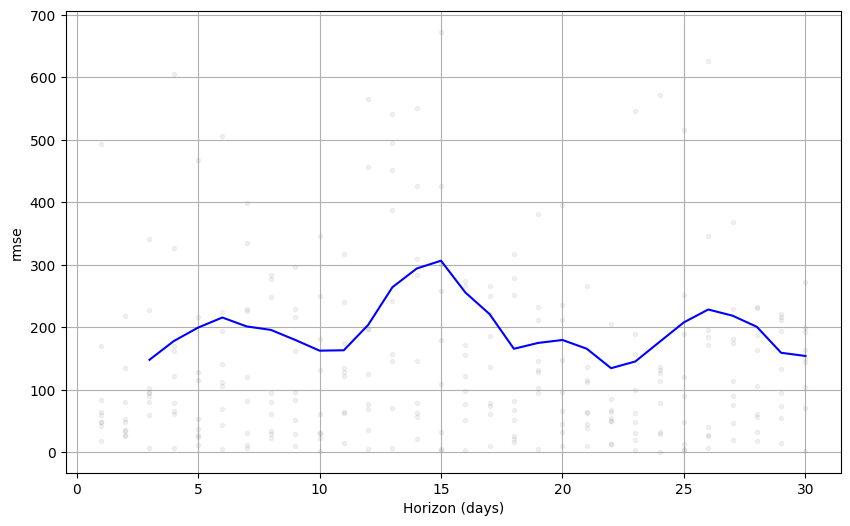

In [76]:
# Main execution
if __name__ == "__main__":
    base_path = r"c:\Users\avrahamma\Documents\School\AI_for_social_good"

    # 1. Load and preprocess data
    df, day_dummies = load_and_preprocess_data(os.path.join(base_path, "data", "paris_bread_sales.csv"))
    
    # 2. Configure and train model
    model = configure_prophet_model()
    add_regressors(model, day_dummies)
    model.fit(df)
    
    # 3. Save trained model 
    with open(os.path.join(base_path, "model", "prophet_model.pkl"), 'wb') as f:
        pickle.dump(model, f)
    
    # 4. Evaluate model
    df_cv, df_p, fig = evaluate_model(model)
    
    # 5. Generate predictions
    future = prepare_future_dataframe(model, df, day_dummies)
    forecast = model.predict(future)
    
    # 6. Visualize and export results
    create_visualization(model, forecast, os.path.join(base_path, "visualizations", "forecast_plot.html"))
    export_results(forecast, os.path.join(base_path, "visualizations", "forecast_results.csv"))